In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/dl_asnmt3/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/dl_asnmt3
/content/drive/MyDrive/dl_asnmt3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import models
from torch.optim import lr_scheduler
import os
import time
import gc
import shutil
import h5py
%matplotlib inline

## Defining network for transfer learning

In [ ]:
class HypNet(nn.Module):
    def __init__(self):
        super(HypNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M']
        self.frontend = make_layers(self.frontend_feat)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(32768, 8192),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 2)
        )

        # self.frontend = models.vgg16_bn(pretrained = True)
        mod = models.vgg16(pretrained = True)
        for i in range(len(list(self.frontend.state_dict().items()))):
            if list(mod.state_dict().items())[i][1].dim()>0:
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
        del mod

    def forward(self,x):
        # print(x.shape)
        x = self.frontend(x)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        x = self.classifier(x)
        return x

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.LeakyReLU(0.2, inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(0.2, inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Loading dataset

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility functions

In [ ]:
def save_checkpoint(state, is_best, epoch, name):
    filename = 'q2_checkpoints/q2_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(ckpt, batch_size):
    model = HypNet().cuda()
    # print(model)
    checkpoint = torch.load('q2_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loader = DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)  
    sm = nn.Softmax(dim=1)  
    total_correct = 0
    total_images = 0
    model.eval()        
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            sm_outputs = sm(outputs)
            outputs = torch.argmax(outputs, dim=1)
            total_correct += (outputs == labels).sum().item()
            total_images += len(labels)
        torch.cuda.empty_cache()
        gc.collect()
    model_accuracy = total_correct / total_images * 100
    return model_accuracy

def plot_train(losses, errors):
    plt.plot(range(len(losses)), losses, label = "Train loss", color='blue')#, markersize=5, marker='o',markerfacecolor='blue')
    plt.plot(range(len(errors)), errors, label = "Val loss", color='red')#, markersize=5, marker='o',markerfacecolor='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val loss')
    plt.legend()
    plt.show()

## Trainer classs

In [ ]:
class CNN_Trainer(object):
    def __init__(self, device, ckpt_name, freeze=True, load_ckpt=None, epochs=25, batch_size=128, lr=0.001, optm='sgd', lr_decay=None, 
                 weight_decay=0):
        self.device = device
        self.lr =  lr
        self.momentum = 0.9
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 2
        self.seed = int(time.time())
        self.print_freq = 1
        self.checkpoint_path = load_ckpt 
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.error_history = []
        # self.img_datasets = img_datasets
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = HypNet().cuda()
        if freeze:
            for param in self.model.frontend.parameters():
                param.requires_grad = False
        
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.lrscheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.2)
        
        if self.checkpoint_path:
            checkpoint = torch.load('q2_checkpoints/'+self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
            self.loss_history = checkpoint['loss_hist']
            self.error_history = checkpoint['err_hist']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=self.batch_size, shuffle=True) \
                           for x in ['train', 'val']}
            self.train_loader = data_loaders['train']
            self.val_loader = data_loaders['val']
            loss = self.train_epoch(epoch)
            if epoch%1 != 0:
                print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)))
                continue
            error = self.validate(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(loss)
            self.error_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(loss,3)),'  Val error:'+str(round(error,3)),'  Best val error:'+str(round(self.best_error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': loss,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch,
                'loss_hist' : self.loss_history,
                'err_hist' : self.error_history
            }, is_best, epoch, self.ckpt_name)
            if isinstance(self.optimizer,torch.optim.SGD) :
                self.lrscheduler.step()
        return self.best_epoch, self.loss_history, self.error_history

    def train_epoch(self, cur_epoch):
        # train_loader = DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.workers, pin_memory=True)        
        self.model.train()        
        losses = 0
        for i, (inputs, labels) in enumerate(self.train_loader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            torch.cuda.empty_cache()
            gc.collect()
        return losses/len(self.train_loader)

    def validate(self, cur_epoch):
        # val_loader = DataLoader(self.valset, self.batch_size, num_workers=self.workers, pin_memory=True)        
        self.model.eval()        
        errors = 0
        for i, (inputs, labels) in enumerate(self.val_loader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                error = self.criterion(outputs, labels)
                errors += error.detach().cpu().item()
            torch.cuda.empty_cache()
            gc.collect()
        return errors/len(self.val_loader)

    def adjust_learning_rate(self, epoch):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= self.lr_decay
            print('LR adjusted')

## Net architecture 

In [ ]:
# print(type(dataloaders))
torch.cuda.empty_cache()
gc.collect()
trainer1 = CNN_Trainer(device, '1_hypn', epochs=25, batch_size=1, lr=0.000001, optm='sgd', lr_decay=None, 
                 weight_decay=1e-4, freeze=True)

cuda:0 Tesla T4


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



HypNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(25

## Training by freezing VGG layers

Epoch:0   Loss:15.58   Val error:6.09   Best val error:6.09
Epoch:1   Loss:10.684   Val error:14.221   Best val error:6.09
Epoch:2   Loss:5.481   Val error:7.647   Best val error:6.09
Epoch:3   Loss:4.48   Val error:2.82   Best val error:2.82
Epoch:4   Loss:2.857   Val error:2.324   Best val error:2.324
Epoch:5   Loss:2.084   Val error:2.0   Best val error:2.0
Epoch:6   Loss:2.278   Val error:2.076   Best val error:2.0
Epoch:7   Loss:1.464   Val error:1.712   Best val error:1.712
Epoch:8   Loss:1.549   Val error:1.464   Best val error:1.464
Epoch:9   Loss:1.175   Val error:1.937   Best val error:1.464
Epoch:10   Loss:1.537   Val error:1.526   Best val error:1.464
Epoch:11   Loss:1.363   Val error:1.152   Best val error:1.152
Epoch:12   Loss:1.35   Val error:1.381   Best val error:1.152
Epoch:13   Loss:1.355   Val error:1.695   Best val error:1.152
Epoch:14   Loss:1.034   Val error:1.301   Best val error:1.152
Epoch:15   Loss:0.847   Val error:1.626   Best val error:1.152
Epoch:16   Los

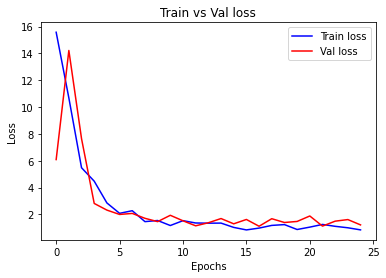

Best epoch: 16


In [ ]:
one_best_epoch, one_losses, one_errors = trainer1.train()
plot_train(one_losses, one_errors)
print('Best epoch:',one_best_epoch)

In [ ]:
acc1 = test_model('q2_ckpt_1_hypn_best',1)
print("Testing Accuracy: ",acc1,'%')

Testing Accuracy:  81.69934640522875 %


## Training by unfreezing VGG layers

cuda:0 Tesla T4


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Epoch:0   Loss:13.248   Val error:6.059   Best val error:6.059
Epoch:1   Loss:4.884   Val error:5.764   Best val error:5.764
Epoch:2   Loss:4.354   Val error:2.888   Best val error:2.888
Epoch:3   Loss:2.662   Val error:2.645   Best val error:2.645
Epoch:4   Loss:2.601   Val error:3.051   Best val error:2.645
Epoch:5   Loss:1.445   Val error:1.326   Best val error:1.326
Epoch:6   Loss:0.931   Val error:1.717   Best val error:1.326
Epoch:7   Loss:1.274   Val error:1.386   Best val error:1.326
Epoch:8   Loss:1.05   Val error:1.414   Best val error:1.326
Epoch:9   Loss:1.21   Val error:1.601   Best val error:1.326
Epoch:10   Loss:0.926   Val error:1.213   Best val error:1.213
Epoch:11   Loss:0.863   Val error:1.242   Best val error:1.213
Epoch:12   Loss:0.821   Val error:1.361   Best val error:1.213
Epoch:13   Loss:0.74   Val error:1.275   Best val error:1.213
Epoch:14   Loss:1.31   Val error:1.244   Best val error:1.213
Epoch:15   Loss:0.773   Val error:1.172   Best val error:1.172
Epoc

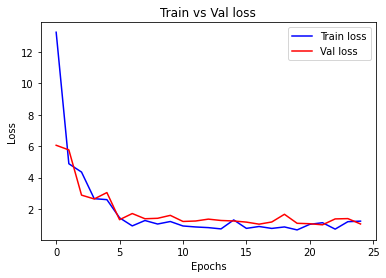

Best epoch: 21


In [ ]:
torch.cuda.empty_cache()
gc.collect()
trainer2 = CNN_Trainer(device, '2_hypn', epochs=25, batch_size=1, lr=0.000001, optm='sgd', lr_decay=None, 
                 weight_decay=1e-4, freeze=False)

two_best_epoch, two_losses, two_errors = trainer2.train()
plot_train(two_losses, two_errors)
print('Best epoch:',two_best_epoch)

In [ ]:
acc2 = test_model('q2_ckpt_2_hypn_best',1)
print("Testing Accuracy: ",acc2,'%')

Testing Accuracy:  79.73856209150327 %


Errors and Accuracies of both the methods are comparable. By freezing, the train loss is a little higher but test accuracy is better. Whereas model with unfreezed layers performs better on train set but slightly worse on test set. Freezing the layers can avoid overfitting the model to trainset.